In [2]:
# Code imports
from lib.opt_types import *
from lib.utils import *

# Image inpainting with proximal methods - 30 points

Image in-painting consists of reconstructing the missing parts of an image from a given incomplete image.

By exploiting some prior knowledge on the image, it is possible to in-paint images that have a large portion of their pixels missing. In this part of the homework, we are going to study different methods to achieve this goal.

We consider a subsampled image $\mathbf{b} = \mathbf{P}_{\Omega} \mathbf{x}$, where $\mathbf{P}_{\Omega} \in \mathbb{R}^{n \times p}$ is an operator that selects only few, $n \ll p := m^2$, pixels from the vectorized image $\mathbf{x} \in \mathbb{R}^p$. Our goal is to reconstruct the original image $\mathbf{x}$.

### Prior knowledge

Image inpainting is impossible without having some prior knowledge on the structure of the true image $\mathbf{x}$. 

We will explore and compare the following prior assumptions we can make on the true image: 
>  **Assumption**: There exists a orthonormal basis $\mathbf{W} \in \mathbb{R}^{p\times p}$ such that $\mathbf{x}$ can be sparsely represented in that basis, i.e, $\mathbf{W} \mathbf{x}$ is a vector with few non-zero coefficients. Said more formally, this assumption states that there exists $\mathbf{\alpha} \in \mathbb{R}^p$ with small $\ell_1$ norm such that $\mathbf{x} = \mathbf{W}^\top\alpha$. We assume that this basis is known and corresponds to the _wavelet basis_. Under this assumption, the reconstruction problem corresponds to solving the following optimization problem:
$$
\min_{\mathbf{\alpha} \in \mathbb{R}^{p}} \underbrace{ \frac{1}{2}\|\mathbf{b} - \mathbf{P}_{\Omega} \mathbf{W}^T\mathbf{\alpha} \|_2^2}_{f_{\ell_1}(\mathbf{\alpha})} + \underbrace{\lambda_{\ell_1} \|\mathbf{\alpha}\|_1}_{g_{\ell_1}(\mathbf{\alpha})},
$$
where $\lambda_{\ell_1}$ is a coefficient we will need to choose.



# PART 1: Optimizing with an $\ell_1$ norm regularization

The optimization problem we are looking to solve have an objective function of the form:
$$
	 f(\mathbf{x}) + g(\mathbf{x}).
$$

These types of objectives are referred to as _composite objectives_ where one term, $f$, is smooth and differentiable and the other term $g$ is non-differentiable.

---

## Code structure:

Recall that we have been working with the `Function` type so far. We will augment this type to represent functions that are not differentiable:

- Given a `Function` `g` you can obtain a subgradient at a point `x` by calling `g.subgrad(x)`.

Moreover, since we are dealing with _composite_ problems with a an objective function that can be written `f + lambda*g`, we define the `CompositeFunction` type defined as
```python
@dataclass
class CompositeFunction:
    f: Function
    g: Function
```

The iterative schemes you will implement will receive a composite function that they can unpack as follows:

```python
def state_update(composite_function, state):
    f, g = composite_function

```

#### Question 1: (5 point)

A first approach to solve a non-smooth optimization problem can be to turn to subgradients. Review slide 42-44 of Lecture 6, and implement `SubG` with $\alpha_k = \frac{0.1}{\sqrt{k}}$.

In [3]:
@dataclass
class SubG_state(OptState):
    x_k: Vector
    k: int 

In [4]:
def SubG_update(composite_function, state):
    f, g, = composite_function
    x_k, k = state

    subgrad_g = g.subgrad(x_k)
    alpha_k=0.1/np.sqrt(k + 1)
    x_k_next = x_k - alpha_k * (f.grad(x_k) + subgrad_g)
    
    # Update the state with the new x_k and increment k
    return SubG_state(x_k=x_k_next, k=k+1)

def SubG_initialize(composite_function, x_zero):
    return SubG_state(x_k=x_zero, k=0)

In [5]:
SubG = OptAlgorithm(name="SubG", init_state=SubG_initialize, state_update=SubG_update)

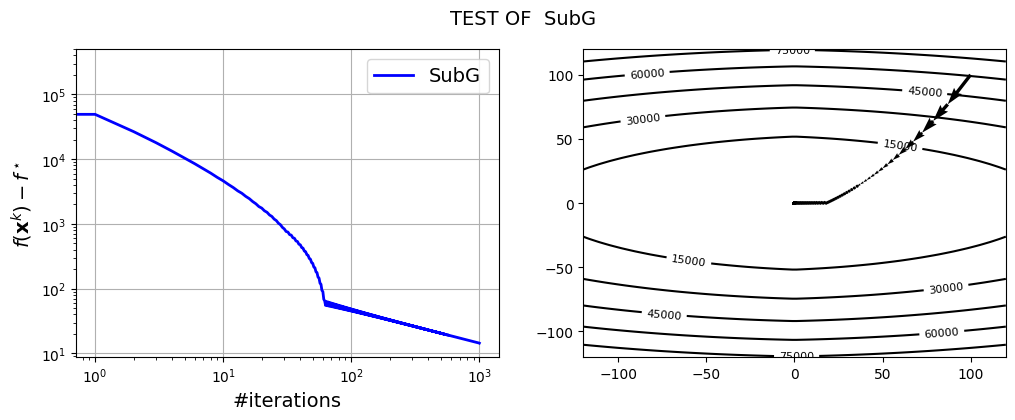

In [6]:
test_composite(SubG)


---

Another, more efficient approach, as we saw in Lecture 7, is to minimize such a function by using proximal gradient algorithms, provided that $g$ is _proximable_ (i.e., its proximal operator is efficient to evaluate). We recall the proximal operator of $g$ as the solution to the following convex problem:
$$
\mathrm{prox}_g(\mathbf{z}) := \mathrm{arg}\min_{\mathbf{y}\in\mathbb{R}^d}\{ g(\mathbf{y}) + \frac{1}{2}\Vert\mathbf{y} - \mathbf{z}\Vert_2^2\}.
$$

#### Question 2 (2 points)

Given $g_{\ell_1}: \mathbb{R}^p \rightarrow \mathbb{R}, \; g_{\ell_1}(\mathbf{x}) :=  \|\mathbf{x}\|_1$,  show that its proximal function can be written as
    $$
    \mathrm{prox}_{\gamma g_{\ell_1}}(\mathbf{z}) = \max(|\mathbf{z}|-\gamma,0) \circ \mathrm{sign}(\mathbf{z}), \; \text{for any }\mathbf{z} \in \mathbb{R}^p,\; \gamma \in \mathbb{R}_+
    $$
			where the operators $\max$, $\mathrm{sign}$ and $\lvert \cdot \lvert$ are applied coordinate-wise to the vector $\mathbf{z}$ and $\circ$ stands for $(\mathbf{x} \circ \mathbf{y})_i = x_i y_i$. Such a regularizer imposes sparsity on the solutions.


ANSWER : What we need to do in order to show the previous result is to solve the following optimization problem:
$$ 
\mathrm{prox}_{\gamma g_{\ell_1}}(\mathbf{z}) = \arg\min_{\mathbf{y} \in \mathbb{R}^p} \left\{ \gamma \|\mathbf{y}\|_1 + \frac{1}{2} \|\mathbf{y} - \mathbf{z}\|_2^2 \right\}. 
$$

Let's consider the $i$-th coordinate of $\mathbf{y}$ and $\mathbf{z}$, We get:
$ \min_{y_i \in \mathbb{R}} \left\{ \gamma |y_i| + \frac{1}{2} (y_i - z_i)^2 \right\}. $

Now the sign part of the above equation gives us a hint that we need to take the cases where $y_i$ is positive and negative

1. **Case 1: $ y_i \geq 0 $**

The objective function becomes:
$\gamma y_i + \frac{1}{2} (y_i - z_i)^2.$ Taking the derivative with respect to $ y_i $ and setting it to zero: $ \gamma + y_i - z_i = 0 $. Hence $ y_i = z_i - \gamma. $ We have: $ y_i = \max(z_i - \gamma, 0). $

2. **Case 2: $ y_i < 0 $**

The objective function becomes:
$ -\gamma y_i + \frac{1}{2} (y_i - z_i)^2. $ Taking the derivative with respect to $ y_i $ and setting it to zero: $ -\gamma + y_i - z_i = 0 $. Hence $ y_i = z_i + \gamma. $ We have: $ y_i = \min(z_i + \gamma, 0). $

We can combine the results of the two cases using the sign function:
$ y_i = \max(|z_i| - \gamma, 0) \circ \mathrm{sign}(z_i). $

Therefore, the proximal operator of $ g_{\ell_1} $ is:
$ \mathrm{prox}_{\gamma g_{\ell_1}}(\mathbf{z}) = \max(|\mathbf{z}| - \gamma, 0) \circ \mathrm{sign}(\mathbf{z})$

This regularizer imposes indeed sparsity on the solutions because it shrinks the components of $\mathbf{z}$ towards zero, setting them to zero if their magnitude is less than $\gamma$.

#### Question 3 (1 point)
 Fill in the function `l1_prox` with the proximal operator of $g_{\ell_1}$.

In [7]:
def l1_prox(gamma, z):
    return np.maximum(np.abs(z) - gamma, 0) * np.sign(z)

#### Question 4 (4 points)

From here on, in order to speed-up the convergence of the optimization, let's assume that the function $f$ has been made to be $\mu$-strongly convex by the addition of an $\ell_2$ regularization term to the function $f$, while the $\ell_1$ term, $g$, has remained unchanged. As such, we must now utilize the strong-convexity versions of the composite optimization algorithms.

Using the information in Lecture 7 slide 21 fill in the codes of the method $ISTA_{\mu}$.

In [9]:
@dataclass
class ISTA_state(OptState):
    x_k: Vector
    k : int

In [10]:
def ISTA_update(composite_function, state):
    f, g = composite_function
    x_k, k = state

    alpha_k = 2 / (f.lips_grad + f.strng_cvx)
    x_k_next = l1_prox(alpha_k, x_k-alpha_k*f.grad(x_k))

    return ISTA_state(x_k=x_k_next, k=k+1)

def ISTA_initialize(composite_function, x_zero):
    return ISTA_state(x_k=x_zero, k=0)

In [11]:
ISTA = OptAlgorithm(name="ISTA", init_state= ISTA_initialize, state_update=ISTA_update)

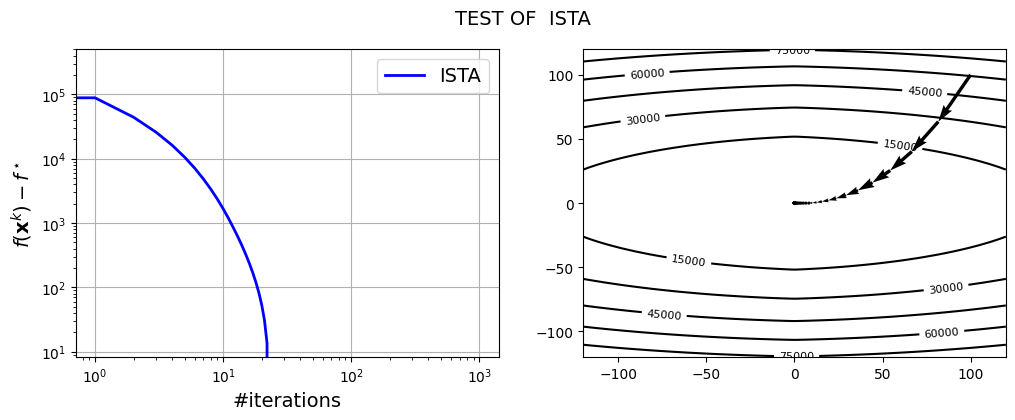

In [12]:
test_composite(ISTA)

#### Question 5  (7 points)

Using the information in Lecture 7 slide 21 fill in the codes of the method FISTA$_{\mu}$.

In [13]:
@dataclass 
class FISTA_state(OptState):
    x_k: Vector
    y_k: Vector
    k: int

In [14]:
import numpy

def FISTA_update(composite_function, state):
    f, g = composite_function
    x_k, y_k, k = state.x_k, state.y_k, state.k

    alpha_k = 1 / f.lips_grad
    c_f = f.lips_grad / f.strng_cvx

    x_k_next = l1_prox(alpha_k, y_k - alpha_k * f.grad(y_k))
    y_k_next = x_k_next + (np.sqrt(c_f) - 1) / (np.sqrt(c_f) + 1) * (x_k_next - x_k)

    return FISTA_state(x_k=x_k_next, y_k=y_k_next, k=k + 1)


def FISTA_initialize(composite_function, x_zero):
    return FISTA_state(x_k=x_zero, y_k=x_zero, k=0)

In [15]:
FISTA = OptAlgorithm(name="FISTA", init_state= FISTA_initialize, state_update=FISTA_update)

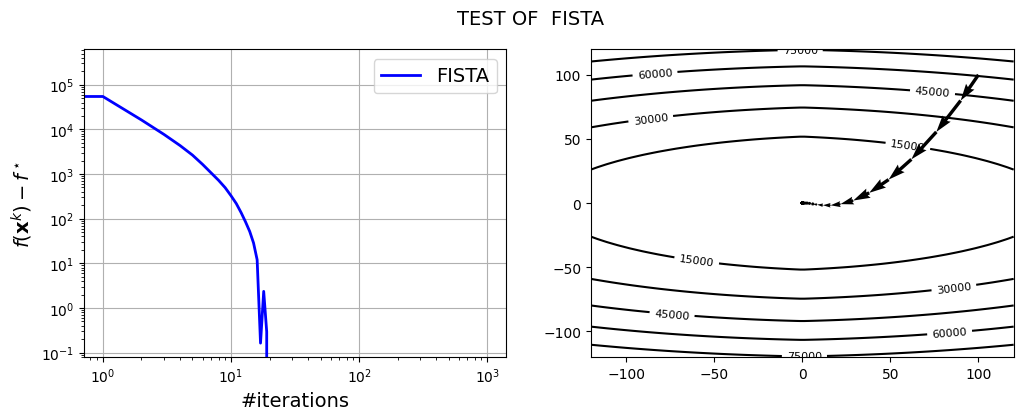

In [16]:
test_composite(FISTA)

#### Question 6  (2 points)

Compare the convergence rates of the three methods and analyze whether the observed results align with their theoretical bounds.

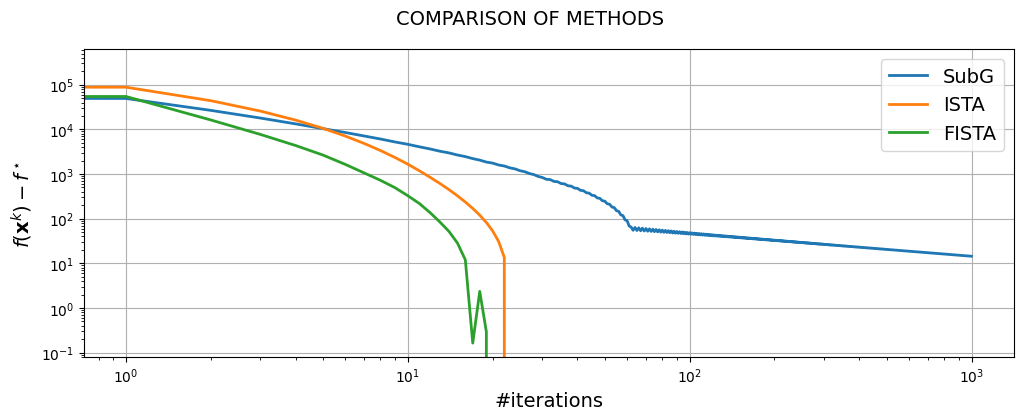

In [17]:
list_of_methods = [SubG, ISTA, FISTA]
compare_composite(list_of_methods)

#TODO

# Part 2: Application


We have now implemented multiple methods that can solve composite optimization problems. We will now apply them to an image inpainting problem.


Take a natural image, or better a picture of you, and place it in the same directory as this notebook.

In [ ]:
from lib.inpainting import *

image = load("lib/alp.jpg") #FILL IN FILE NAME

With this image in hand, let us subsample it and try to reconstruct the original.

In [ ]:
subsampled = show_subsampled(image)

In the following cells we will define the optimization problems we need to solve to perform the reconstruction.

- We provide you with a function `P` that acts like the matrix $\mathbf{P}_{\Omega}$. That is, given a vector `x`, it returns a subsampled vector `P(x)` that corresponds to $\mathbf{P}_{\Omega} \mathbf{x}$. We also give you `P_T` which acts like $\mathbf{P}^\top$.
- We provide you with a function `W` and `W_T` that act like the matrix $\mathbf{W}$ and $\mathbf{W^\top}$ respectively. That is, for a vector `x`, `W(x)` and `W_T(x)` return $\mathbf{W}\mathbf{x}$ and $\mathbf{W^\top}\mathbf{x}$ respectively.

__(a)__ (1 point) Using these provided functions, define the observed variable `b` in the cell below.

In [ ]:
from lib.inpainting import P, P_T, W, W_

x = image.reshape(-1) #flattened image

b = #FILL

__(b)__ (1 point) Now define the function `f_l1` as described earlier in the problem text.

In [ ]:
mu = ... # Desired strong convexity of f
def f_l1(alpha):
    #FILL

__(c)__ (1 point) Write the gradient of $f_{\ell_1}(\mathbf{\alpha})$.

In [ ]:
def grad_f_l1(alpha):
    #FILL

__(d)__ (1 points) Find the Lipschitz constant of $\nabla_\mathbf{\alpha} f_{\ell_1}(\mathbf{\alpha})$ analytically and fill it in the cell below. 

In [ ]:
lips_grad_f_l1 = #FILL

We have all the necessary ingredients to define the smooth part of our composite objective:

In [ ]:
f_l1 = Function(f = f_l1, grad=grad_f_l1, lips_grad = lips_grad_f_l1, strng_cvx=mu)

For the non-smooth term, we define a regularizer built around the `l1` function that re-uses the `l1_prox` function you implemented earlier:

In [ ]:
l1 = Function(f = lambda x: np.sum(np.abs(x), axis=0), prox=l1_prox)

g_l1 = Regularizer(l1)

In [ ]:
composite_objective = CompositeFunction(f=f_l1, g=g_l1)

With the objective defined, we provide you with a function with the following signature:
```python
solve_composite(method: OptAlgorithm, composite_objective: CompositeFunction, lmda: float, max_iterations: int) -> Vector
```

In other words, the function takes an optimization algorithm `method`, a CompositeFunction `composite_objective`, a regularization parameter `lmda` and a number of iterations `max_iterations` and returns a vector which is the last iterate given by the `method`.



In [ ]:
from lib.inpainting import solve_composite

__(e)__ (5 points) Using `solve_composite` reconstruct the subsampled image. Recall that the composite problem solves for $\mathbf{\alpha}$ so you need to convert the output back to an image and visualize it.

Select a reasonable value for `lmda` or (BONUS) using the function `solve_composite` and the `PSNR` metric, find the best value for `lmda`.

In [ ]:
output = 
flat_image_out = 
image_out = 

In [ ]:
show(true = image, subsampled=subsampled, estimated=image_out)